In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

import cv2

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

df = pd.read_csv('Data_Entry_2017.csv')
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
29060,00007572_001.png,Pneumothorax,1,7572,42,F,PA,2048,2500,0.168,0.168,NaN
4796,00001285_002.png,Edema|Infiltration|Pneumonia,2,1285,33,M,AP,2500,2048,0.168,0.168,NaN
44628,00011470_005.png,Atelectasis,5,11470,42,M,PA,2992,2991,0.143,0.143,NaN


In [3]:
data_sample = pd.read_csv('sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1283,00006731_002.png,No Finding,2,6731,054Y,M,AP,2500,2048,0.171,0.171
3667,00018023_000.png,No Finding,0,18023,043Y,F,PA,2048,2500,0.168,0.168
1219,00006434_003.png,Infiltration|Nodule,3,6434,039Y,M,PA,2500,2048,0.171,0.171


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [4]:
## EDA
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.sample(3)



All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
54020,00013615_031.png,Infiltration,31,13615,10,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50502,00012804_010.png,Effusion,10,12804,62,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84041,00020662_001.png,No Finding,1,20662,27,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Demographic of patient population
There are patients with age over 148 and up to 414 years old. We will treat these data as errornous and assume the population age up to 95 years old.

In [5]:
df['Patient Age'].sort_values().tail(20)

74735      94
74736      94
578        94
58464      95
48284     148
55742     148
62929     149
58650     150
78795     151
74884     152
95794     153
98495     154
101194    155
104590    155
84810     411
85404     412
20852     412
91369     412
86264     413
46965     414
Name: Patient Age, dtype: int64

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

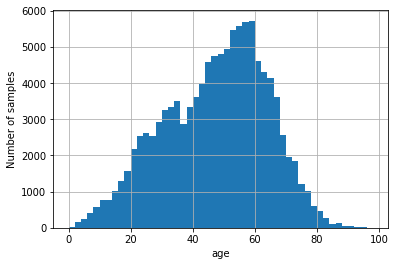

In [6]:
# Age distirbution of all patients
df['Patient Age'].hist(bins=np.arange(0,100,2))
plt.ylabel('Number of samples')
plt.xlabel('age')
df['Patient Age'].describe()

In [7]:
# Gender
df.groupby(['Patient Gender']).size()

Patient Gender
F    48780
M    63340
dtype: int64

In [8]:
# Xray View Position distribution
df.groupby(['View Position'])['Image Index'].count()

View Position
AP    44810
PA    67310
Name: Image Index, dtype: int64

Text(0.5, 0, 'Diseases')

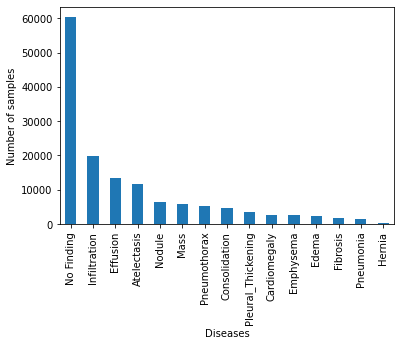

In [9]:
# Distribution of diseases
df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Number of samples')
plt.xlabel('Diseases')

## We look at distribution of pneumonia patients

,count,mean,std,min,25%,50%,75%,max
Pneumonia,,,,,,,,
0.0,110689.0,46.926985,16.791759,1.0,35.0,49.0,59.0,414.0
1.0,1431.0,44.927324,20.129866,2.0,31.0,46.0,59.0,412.0


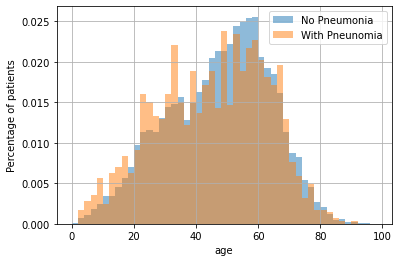

In [11]:
# age distribution. No much difference between patient with or without pneumonia
df.groupby(['Pneumonia'])['Patient Age'].hist(bins=np.arange(0,100,2), density=True, alpha=0.5)
plt.legend(['No Pneumonia', 'With Pneunomia'])
plt.ylabel('Percentage of patients')
plt.xlabel('age')
df.groupby(['Pneumonia'])['Patient Age'].describe()

In [21]:
df['Patient Gender'].value_counts()/len(df)

M    0.56493
F    0.43507
Name: Patient Gender, dtype: float64

In [18]:
# Ratio of gender with pneumonia
#total_pneumonia_patient = df[df['Pneumonia']==1]['Patient Gender'].value_counts().sum()
df[df['Pneumonia']==1]['Patient Gender'].value_counts()/len(df[df['Pneumonia']==1])

M    0.585604
F    0.414396
Name: Patient Gender, dtype: float64

In [20]:
# Ratio of gender without pneumonia
df[df['Pneumonia']==0]['Patient Gender'].value_counts()/len(df[df['Pneumonia']==0])

M    0.564663
F    0.435337
Name: Patient Gender, dtype: float64

In [12]:
print("Percentage of pneumonia positive cases %.2f  percent"%(100*total_pneumonia_patient/len(df)))
print("Patient with pneumonia %d, people without pneumonia %d"%(total_pneumonia_patient, len(df)))

Percentage of pneumonia positive cases 1.28  percent
Patient with pneumonia 1431, people without pneumonia 112120


## There is big class imbalance, so we will need to balance the training dataset.

## We look at what are the most common diseases that link to pneumonia

Text(0.5, 1.0, 'Diseases occur together with pneumonia')

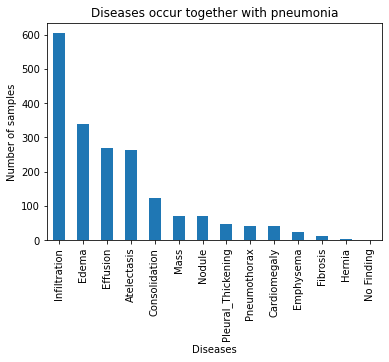

In [13]:
all_labels.remove('Pneumonia')
df[df['Pneumonia']==1][all_labels].sum().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Number of samples')
plt.xlabel('Diseases')
plt.title('Diseases occur together with pneumonia')

# Let's look at some images
## Let's look at patient without diseases

00000002_000.png


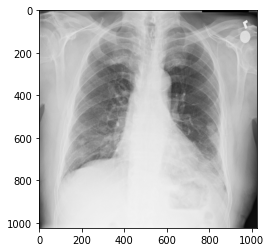

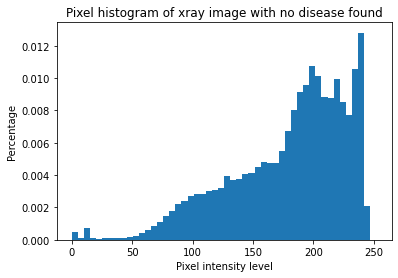

00000005_000.png


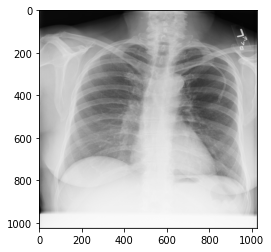

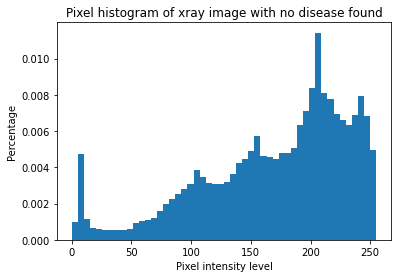

00000005_001.png


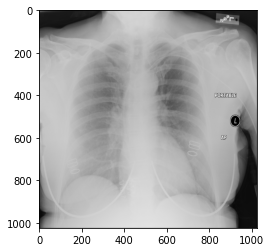

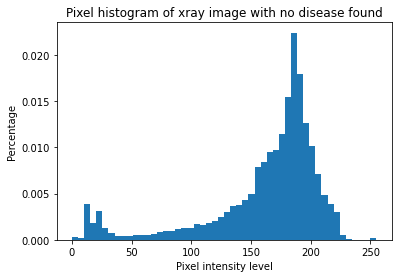

In [14]:
for index, row in df[df['Finding Labels']=="No Finding"].head(3).iterrows():
    fname = row['Image Index']
    print(fname)
    img = cv2.imread(os.path.join("./images/", fname))
    plt.imshow(img)
    plt.show()
    _ = plt.hist(img.reshape(-1), bins=50, density=True)
    plt.ylabel('Percentage')
    plt.xlabel('Pixel intensity level')    
    plt.title('Pixel histogram of xray image with no disease found')
    plt.show()

00000061_015.png


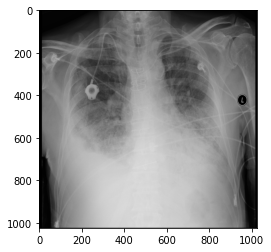

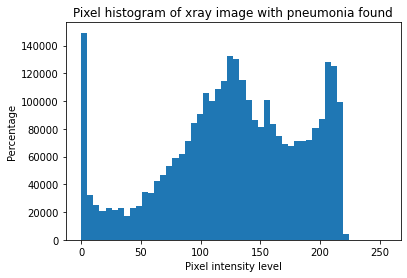

00000144_001.png


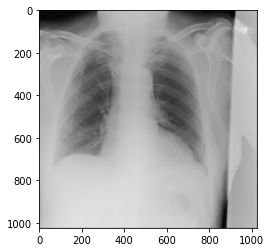

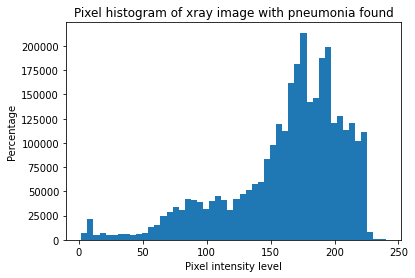

00000165_001.png


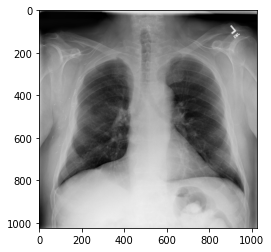

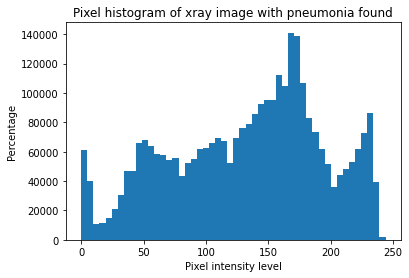

In [15]:
# images with pnemonua
for index, row in df[df['Finding Labels']=="Pneumonia"].head(3).iterrows():
    fname = row['Image Index']
    print(fname)
    img = cv2.imread(os.path.join("./images/", fname))
    plt.imshow(img)
    plt.show()
    _ = plt.hist(img.reshape(-1), bins=50)
    plt.ylabel('Percentage')
    plt.xlabel('Pixel intensity level')    
    plt.title('Pixel histogram of xray image with pneumonia found')
    plt.show()

00000005_006.png


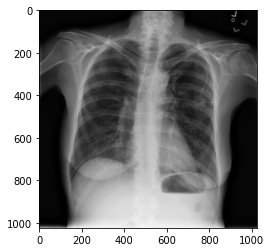

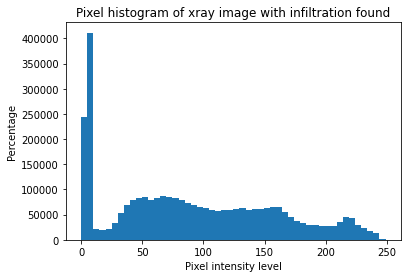

00000010_000.png


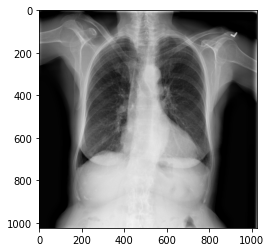

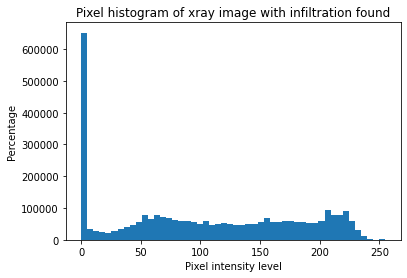

00000011_005.png


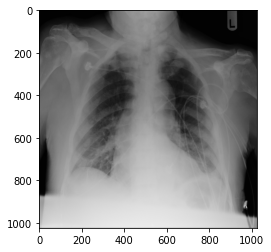

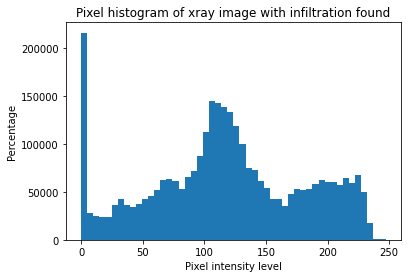

In [16]:
# images with filtration
for index, row in df[df['Finding Labels']=="Infiltration"].head(3).iterrows():
    fname = row['Image Index']
    print(fname)
    img = cv2.imread(os.path.join("./images/", fname))
    plt.imshow(img)
    plt.show()
    _ = plt.hist(img.reshape(-1), bins=50)
    plt.ylabel('Percentage')
    plt.xlabel('Pixel intensity level')    
    plt.title('Pixel histogram of xray image with infiltration found')      
    plt.show()

# Discussions
From the histogram and images, it looks like that:
- With untrained naked eyes, it is difficult differentiate pixel distribution of different diseases. However, it does look like xray with pneumonia or infiltration tend to have more peaks at lower intensity.
- the pixel value distribution can be influenced by the black borders, could potentially use random cropping in data augmentation when training neural network.